In [3]:
import gc
import glob
import random
import os 
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scp
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms 
import skimage.io as skio
from torch.utils.data import Dataset, DataLoader

In [4]:
#writing the model
class MyCNN(nn.Module):
  def __init__(self, num_channels=3, num_out_ch=[8, 16], img_w=100, img_h=100, num_classes=102):
    super(MyCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.fc = nn.Linear(in_features = int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features=num_classes)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = self.fc(x.reshape(x.shape[0], -1))

    return x

model = MyCNN()
x = torch.randn(32, 3, 100, 100)
y = model(x)
print(y.shape)

torch.Size([32, 102])


In [5]:
# Hyperparameters
NUM_OUT_CH = [8, 16]
IMAGE_W = 200
IMAGE_H = 200
BATCH_SIZE = 64
NUM_EPOCHS = 4
LR = 0.001

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# model
model = MyCNN(num_channels=3, num_out_ch=NUM_OUT_CH, img_w=IMAGE_W, img_h=IMAGE_H, num_classes=102)
model = model.to(device)

# Optimiser
optimiser = optim.Adam(model.parameters(), lr = LR)

# Loss Function
criterion = nn.CrossEntropyLoss()
     

cpu


,image_path,image_label
0,/Users/rohandhar/Desktop/INTexam/jpg/image_000...,76
1,/Users/rohandhar/Desktop/INTexam/jpg/image_000...,76
2,/Users/rohandhar/Desktop/INTexam/jpg/image_000...,76
3,/Users/rohandhar/Desktop/INTexam/jpg/image_000...,76
4,/Users/rohandhar/Desktop/INTexam/jpg/image_000...,76
...,...,...
8184,/Users/rohandhar/Desktop/INTexam/jpg/image_081...,61
8185,/Users/rohandhar/Desktop/INTexam/jpg/image_081...,61
8186,/Users/rohandhar/Desktop/INTexam/jpg/image_081...,61
8187,/Users/rohandhar/Desktop/INTexam/jpg/image_081...,61


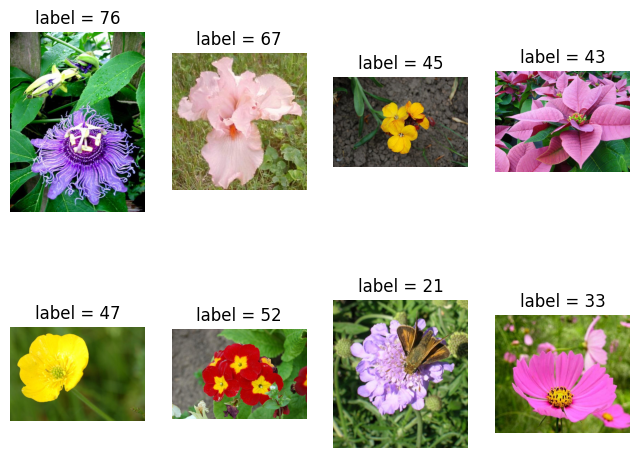

In [6]:
#visualising the data
data_path = '/Users/rohandhar/Desktop/INTexam/jpg/'
label_path = '/Users/rohandhar/Desktop/INTexam/imagelabels.mat'
label_arr = scp.loadmat(label_path)['labels']
label_arr -= 1

#lists the files in a specific directory
# sorted(os.listdir(data_path))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,6))
image_num = random.sample(range(1,8190), 8)
for i in range(2):
  for j in range(4):
    image = skio.imread(os.path.join(data_path, f'image_{image_num[i*4+j]:05}.jpg'))
    ax[i,j].imshow(image)
    ax[i,j].axis('off')
    ax[i,j].set_title(f'label = {label_arr[0,image_num[i*4+j]]}')

# data frame: index: 8189; columns: 'path', 'label
labels_list = list(label_arr[0, :])
image_path_list = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
metadata = pd.DataFrame(
    {'image_path': image_path_list,
     'image_label': labels_list}
)
metadata

In [9]:
class MyFlowerDataset(Dataset):
  def __init__(self, metadata, transform=None):
    self.metadata = metadata
    self.transform = transform

  def __len__(self):
    return len(self.metadata)

  def __getitem__(self, idx):
    image_path = self.metadata.iloc[idx, 0]
    image = skio.imread(image_path)
    label = torch.tensor(int(metadata.iloc[idx, 1]))
    label = F.one_hot(label, num_classes=102)
    label = label.float()
    if self.transform:
      image = self.transform(image)

    return (image, label)

flower_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = MyFlowerDataset(metadata, transform = flower_transform)

# Splitting dataset into train and test
train_set, test_set = torch.utils.data.random_split(dataset, [6500, 1689])

# defining the dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


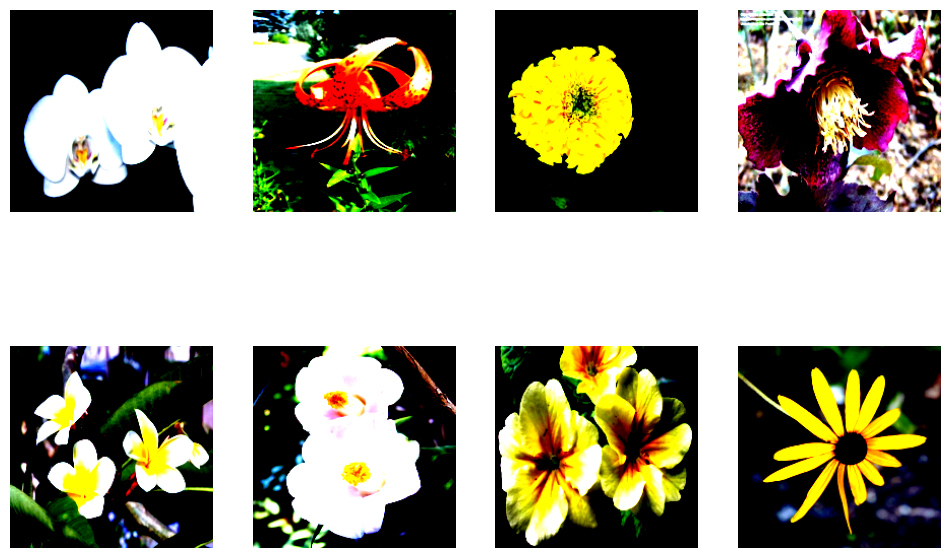

In [10]:
for x,y in train_loader:
  x = x.to(device)
  fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,8))
  for i in range(2):
    for j in range(4):
      ax[i,j].imshow(x[i*4+j].cpu().permute(1,2,0))
      ax[i,j].axis('off')
  break


In [11]:
def check_accuracy(loader, model):
    num_corrects = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            
            #calculating the accuracy
            _, labels = y.max(1)
            _, predictions = y_hat.max(1)
            num_corrects += (predictions == labels).sum()
            num_samples += predictions.size(0)
        print(f"Accuracy: {num_corrects/num_samples*100}")



for epoch in range(NUM_EPOCHS):
  running_loss = 0
  for index, (x,y) in enumerate(train_loader):
    # send the data to the device
    x = x.to(device)
    y = y.to(device)

    # forward
    y_hat = model(x)
    loss = criterion(y_hat, y)
    running_loss += loss

    # backward
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  print(f"Epoch {epoch}: loss: {running_loss}")
  check_accuracy(test_loader, model)

Epoch 0: loss: 364.7976989746094
Accuracy: 33.806983947753906
Epoch 1: loss: 131.34967041015625
Accuracy: 39.431617736816406
Epoch 2: loss: 26.161344528198242
Accuracy: 37.892242431640625
Epoch 3: loss: 4.502187728881836
Accuracy: 39.01716995239258
